In [2]:
import pandas as pd
import numpy as np
from IPython.display import Image, display
from ipywidgets import IntProgress

df_raw = pd.read_csv("./datasets/20A_02.CSV")
df_raw["t"] = df_raw["in s"]
df_raw["Va"] = df_raw["C1 in V"]
df_raw["Ia"] = df_raw["C2 in A"]
df_raw["n"] = df_raw["C3 in V"]

In [3]:
def get_frequency(data, batch_size, time_step):
    fourier = abs(np.fft.fft(data))
    frequencies = np.fft.fftfreq(batch_size, d=time_step)

    half_length = int(frequencies.shape[0]/2)

    arg_max = fourier[1:half_length].argmax()
    max_frequency = frequencies[1:half_length][arg_max]
    return max_frequency

def get_batch(data, label, k, batch_size):
    return data[label].iloc[k*batch_size:(k+1)*batch_size]

In [14]:
data = {
    "t": (df_raw["t"] - df_raw["t"].min()).array,
    "Va": df_raw["Va"].array,
    "Ia": df_raw["Ia"].array,
    "Wm": [],
}
time_step = df_raw["t"].diff().iloc[1]

print("Time step:", time_step)

batch_size = 10000
n = int(df_raw["t"].shape[0]/batch_size)

print("Batches:", n)

f = IntProgress(min=0, max=n) # instantiate the bar
display(f)

num_steps = 2048
start = True
threshold_step = 4

for k in range(n):
    n_batch = get_batch(df_raw, "n", k, batch_size)
    
    step_count = 0
    stepping = False

    for step in n_batch.array:
        if not stepping and step > threshold_step:
            stepping = True
        elif stepping and step < threshold_step:
            stepping = False
            step_count += 1

    W = (step_count / num_steps) / (time_step * batch_size) * 2 * np.pi
    data["Wm"].append(W)

    f.value += 1

data["Wm"] = np.interp(data["t"], data["t"][::batch_size], data["Wm"])

df = pd.DataFrame(data)
df

Time step: 2.399999999985747e-07
Batches: 100


IntProgress(value=0)

,t,Va,Ia,Wm
0,0.000000e+00,0.016113,-0.317383,0.000000
1,2.400000e-07,-0.042480,-0.122070,0.000000
2,4.800000e-07,-0.013184,-0.122070,0.000000
3,7.200000e-07,0.016113,0.024414,0.000000
4,9.600000e-07,0.001465,-0.170898,0.000000
...,...,...,...,...
999995,2.399988e-01,12.086400,1.293950,550.954766
999996,2.399990e-01,12.071800,1.489260,550.954766
999997,2.399993e-01,12.057100,1.245120,550.954766
999998,2.399995e-01,12.013200,1.293950,550.954766


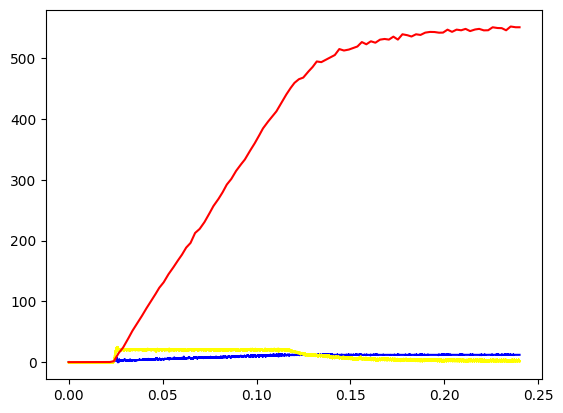

In [15]:
import matplotlib.pyplot as plt

plt.plot(df["t"], df["Va"], c="blue")
plt.plot(df["t"], df["Ia"], c="yellow")
plt.plot(df["t"], df["Wm"], c="red")

plt.show()

In [16]:
# Circuit Equation  
# Va = i*Ra + L*di/dt + Ke*w
# Tm = Kt*i = TL + Jm*dw/dt + Bm*w

Ra = 0.091
Ke = 18.803 / 1000

t = np.array(df["t"].array)

Va = np.array(df["Va"].array)

Ia = np.array(df["Ia"].array)
dIa = np.concatenate((np.zeros(1), np.diff(Ia)/np.diff(t)))

Wm = np.array(df["Wm"].array)
dWm = np.concatenate((np.zeros(1), np.diff(Wm)/np.diff(t)))

TL = 0

In [17]:
Xy = np.zeros((3,1))
XX_T = np.zeros((3,3))

# Va - i*Ra - Ke*w = L*di/dt + 0 + 0
# Kt*i - TL = 0 + Jm*dw/dt + Bm*w

n = len(t)

f = IntProgress(min=0, max=int(n/100)) # instantiate the bar
display(f)

for k in range(n):
    y = np.vstack([Va[k] - Ia[k]*Ra - Ke*Wm[k], Ke*Ia[k] - TL])
    X = np.array([
        [dIa[k], 0, 0],
        [0, dWm[k], Wm[k]],
    ])
    Xy += X.T @ y
    XX_T += X.T @ X 
    if k % 100 == 0:
        f.value += 1

print("Batch size:", batch_size)
theta = np.linalg.inv(XX_T) @ Xy
print(theta)

IntProgress(value=0, max=10000)

Batch size: 10000
[[-7.98540852e-09]
 [ 6.35837096e-05]
 [ 1.20983551e-04]]


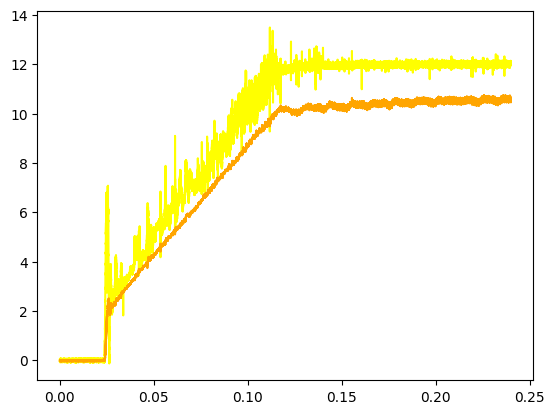

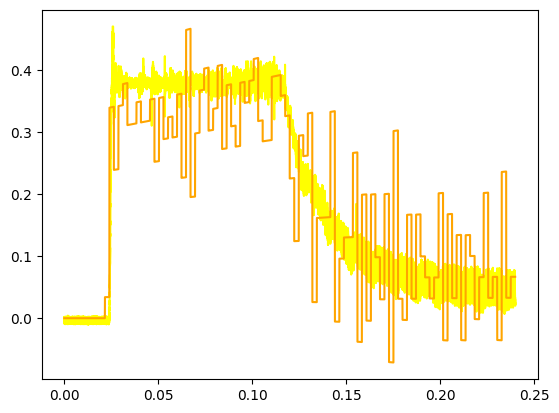

In [18]:
# Circuit Equation  
# Va = i*Ra + L*di/dt + Ke*w
# Tm = Kt*i = TL + Jm*dw/dt + Bm*w

La, Jm, Bm = theta.T[0][:3]

Va_pred = Ia*Ra + La*dIa + Ke*Wm
Tm = Ke*Ia
Tm_pred = TL + Jm*dWm + Bm*Wm

plt.plot(t, Va, c="yellow")
plt.plot(t, Va_pred, c="orange")
plt.show()

plt.plot(t, Tm, c="yellow")
plt.plot(t, Tm_pred, c="orange")
plt.show()